In [9]:
using LazySets, Plots, ForwardDiff

LazySets.default_tolerance(::Type{<:ForwardDiff.Dual}) = LazySets.default_tolerance(Float64)

In [10]:
function foo(a₁_x, a₁_y, a₂_x, a₂_y, a₃_x, a₃_y,
             b₁_x, b₁_y, b₂_x, b₂_y, b₃_x, b₃_y)
    
    p = VPolygon([a₁_x a₂_x a₃_x
                  a₁_y a₂_y a₃_y])

    q = VPolygon([b₁_x b₂_x b₃_x
                  b₁_y b₂_y b₃_y])
    
    area(q)
end

foo (generic function with 1 method)

In [13]:
v = [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]
ForwardDiff.gradient(x -> foo(x...), v)

12-element Array{Float64,1}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
 -0.5
 -0.5
  0.5
  0.0
  0.0
  0.5

In [43]:
using LazySets: _leq

function _isinside(p, a, b)
    @inbounds begin
        α = (b[1] - a[1]) * (p[2] - a[2])
        β = (b[2] - a[2]) * (p[1] - a[1])
    end
    return !_leq(α, β)
end

function _intersection_line_segments(a, b, s, f)
    @inbounds begin
        dc = [a[1] - b[1], a[2] - b[2]]
        dp = [s[1] - f[1], s[2] - f[2]]
        n1 = a[1] * b[2] - a[2] * b[1]
        n2 = s[1] * f[2] - s[2] * f[1]
        n3 = 1.0 / (dc[1] * dp[2] - dc[2] * dp[1])

        α = (n1 * dp[1] - n2 * dc[1]) * n3
        β = (n1 * dp[2] - n2 * dc[2]) * n3
    end
    return [α, β]        
end

function _intersection_vrep(spoly::Vector{VT}, cpoly::Vector{VT}) where {N, VT<:AbstractVector{N}}
    outarr = spoly
    q = cpoly[end]
    for p in cpoly
        inarr = outarr
        outarr = Vector{VT}()
        s = inarr[end]
        for vtx in inarr
            if _isinside(vtx, q, p)
                if !_isinside(s, q, p)
                    push!(outarr, _intersection_line_segments(q, p, s, vtx))
                end
                push!(outarr, vtx)
            elseif _isinside(s, q, p)
                push!(outarr, _intersection_line_segments(q, p, s, vtx))
            end
            s = vtx
        end
        q = p
    end
    outarr
end

function _intersection_vrep(A::VPolygon, B::VPolygon)
    vA = vertices_list(A)
    vB = vertices_list(B)
    vC = _intersection_vrep(vA, vB)
    return VPolygon(vC)
end 

_intersection_vrep (generic function with 2 methods)

In [46]:
A = [[50, 150.], [200, 50.], [350, 150], [350, 300.],
     [250, 300.], [200, 250.], [150, 350.], [100, 250.], [100, 200.]]  |> VPolygon

B = [[100, 100.], [300, 100.], [300, 300.], [100, 300.]] |> VPolygon

C = _intersection_vrep(A, B)

VPolygon{Float64,Array{Float64,1}}([[100.0, 116.66666666666667], [125.00000000000001, 100.0], [275.0, 100.0], [300.0, 116.66666666666667], [300.0, 299.99999999999994], [125.0, 300.0], [100.0, 250.0]])

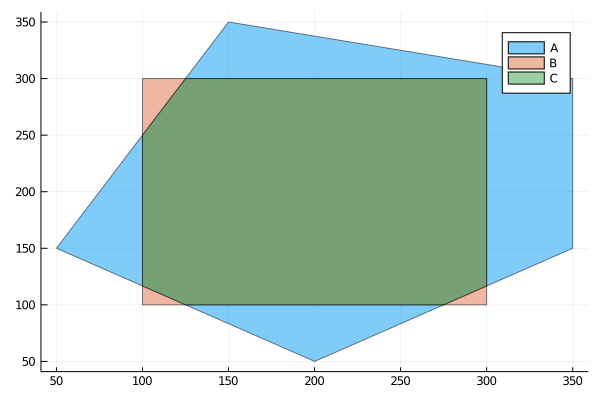

In [49]:
plot(A, lab="A")
plot!(B, lab="B")
plot!(C, lab="C")

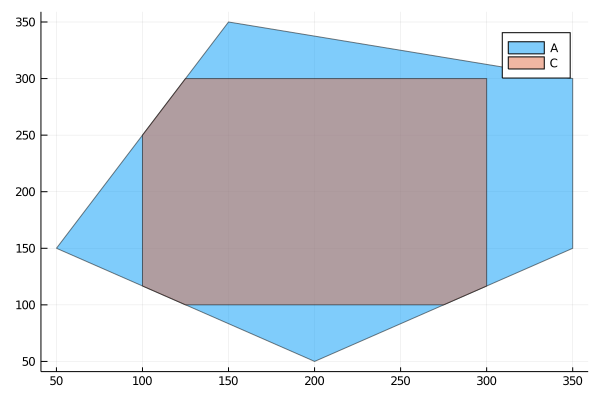

In [50]:
plot(A, lab="A")
#plot!(B, lab="B")
plot!(C, lab="C")

In [22]:
using BenchmarkTools, StaticArrays

In [51]:
As = VPolygon([SVector{2}(v) for v in vertices_list(A)])
Bs = VPolygon([SVector{2}(v) for v in vertices_list(B)]);

In [52]:
@btime _intersection_vrep($A, $B)

  1.558 μs (43 allocations: 3.61 KiB)


VPolygon{Float64,Array{Float64,1}}([[100.0, 116.66666666666667], [125.00000000000001, 100.0], [275.0, 100.0], [300.0, 116.66666666666667], [300.0, 299.99999999999994], [125.0, 300.0], [100.0, 250.0]])

In [53]:
@btime _intersection_vrep($As, $Bs)

  1.406 μs (43 allocations: 4.16 KiB)


VPolygon{Float64,SArray{Tuple{2},Float64,1,2}}(SArray{Tuple{2},Float64,1,2}[[100.0, 116.66666666666667], [125.00000000000001, 100.0], [275.0, 100.0], [300.0, 116.66666666666667], [300.0, 299.99999999999994], [125.0, 300.0], [100.0, 250.0]])

In [36]:
_intersection_vrep(As, Bs)

VPolygon{Float64,SArray{Tuple{2},Float64,1,2}}(SArray{Tuple{2},Float64,1,2}[[100.0, 116.66666666666667], [125.00000000000001, 100.0], [275.0, 100.0], [300.0, 116.66666666666667], [300.0, 299.99999999999994], [125.0, 300.0], [100.0, 250.0]])

In [57]:
Q = tohrep(As)
P = tohrep(Bs)

HPolygon{Float64,Array{Float64,1}}(HalfSpace{Float64,Array{Float64,1}}[HalfSpace{Float64,Array{Float64,1}}([200.0, 0.0], 60000.0), HalfSpace{Float64,Array{Float64,1}}([0.0, 200.0], 60000.0), HalfSpace{Float64,Array{Float64,1}}([-200.0, 0.0], -20000.0), HalfSpace{Float64,Array{Float64,1}}([0.0, -200.0], -20000.0)])

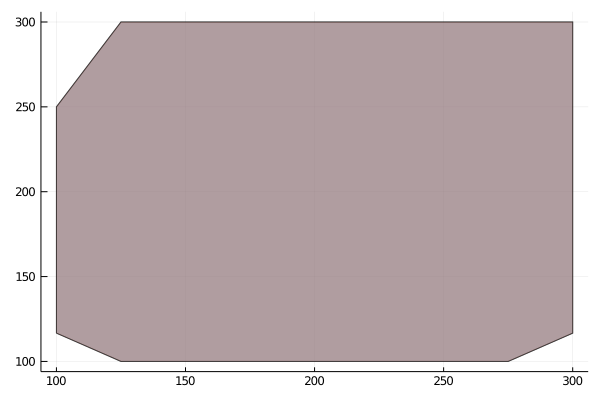

In [59]:
R = intersection(Q, P)
plot(R)
plot!(C)

In [60]:
@btime intersection($Q, $P)

  3.040 μs (77 allocations: 5.73 KiB)


HPolygon{Float64,Array{Float64,1}}(HalfSpace{Float64,Array{Float64,1}}[HalfSpace{Float64,Array{Float64,1}}([200.0, 0.0], 60000.0), HalfSpace{Float64,Array{Float64,1}}([0.0, 200.0], 60000.0), HalfSpace{Float64,Array{Float64,1}}([-200.0, 100.0], 5000.0), HalfSpace{Float64,Array{Float64,1}}([-200.0, 0.0], -20000.0), HalfSpace{Float64,Array{Float64,1}}([-100.0, -150.0], -27500.0), HalfSpace{Float64,Array{Float64,1}}([0.0, -200.0], -20000.0), HalfSpace{Float64,Array{Float64,1}}([100.0, -150.0], 12500.0)])

In [61]:
function foo2(a₁_x, a₁_y, a₂_x, a₂_y, a₃_x, a₃_y,
              b₁_x, b₁_y, b₂_x, b₂_y, b₃_x, b₃_y)
    
    p = VPolygon([a₁_x a₂_x a₃_x
                  a₁_y a₂_y a₃_y])

    q = VPolygon([b₁_x b₂_x b₃_x
                  b₁_y b₂_y b₃_y])
    
    _intersection_vrep(p, q) |> area
end

foo2 (generic function with 1 method)

In [64]:
v = [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]
ForwardDiff.gradient(x -> foo2(x...), v)

12-element Array{Float64,1}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
 -0.5
 -0.5
  0.5
  0.0
  0.0
  0.5

In [63]:
foo2(v...)

0.5

In [ ]:
struct Point
    x::Float64
    y::Float64
end

In [ ]:
using LazySets

In [ ]:
A = VPolygon([[p.x, p.y] for p in subjectp])
B = VPolygon([[p.x, p.y] for p in clipp])

In [ ]:
using Plots

In [ ]:
plot(A, lab="A")
plot!(B, lab="B")

In [ ]:
C = VPolygon([[p.x, p.y] for p in clipped])

In [ ]:
plot!(C, lab="C")

In [ ]:
using BenchmarkTools

In [ ]:
@btime clipSH($subjectp, $clipp);

In [ ]:
Ap = tohrep(A)
Bp = tohrep(B)

@btime LazySets.intersection($Ap, $Bp)

In [ ]:
using Polyhedra

In [ ]:
@btime LazySets.intersection($A, $B);

In [ ]:
using Luxor

Drawing(400, 400, "intersecting-polygons.png")
background("white")
sethue("red")
poly(subjectp, :stroke, close=true)
sethue("blue")
poly(clipp, :stroke, close=true)

sethue("gold")
poly(clipped, :fill, close=true)
finish()
preview()
println(clipped)

----

In [1]:
using Revise, LazySets

┌ Info: Precompiling LazySets [b4f0291d-fe17-52bc-9479-3d1a343d9043]
└ @ Base loading.jl:1278


In [ ]:
\empty